special credits :  https://github.com/worasom/aqi_thailand

In [13]:
import sys
from pathlib import Path
import seaborn as sns
import pandas as pd
import statsmodels.api as sm
import datetime 
import matplotlib.dates as mdates
import matplotlib as mpl
from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from mpl_toolkits.axes_grid1.colorbar import colorbar

In [14]:
#inspecting the top of the files 
with open('data/Bangkok.txt','r') as f:
    for i in range(12):
        print(f.readline())

% Country: Thailand

% City: Bangkok

% City (ASCII): Bangkok

% Region: Bangkok

% Region (ASCII): Bangkok

% Population: 5104476

% Latitude: 13.754

% Longitude: 100.5014

% Time Zone: Asia/Bangkok

% Year, Month, Day, UTC Hour, PM2.5, PM10_mask, Retrospective

2016	3	3	8	62.9	1.00	0

2016	3	3	9	62.9	1.00	0



In [15]:
#load bangkok data
pm25 = pd.read_csv('data/Bangkok.txt', sep='\t', 
                   header=None, skiprows=10)
pm25.head()

,0,1,2,3,4,5,6
0,2016,3,3,8,62.9,1.0,0
1,2016,3,3,9,62.9,1.0,0
2,2016,3,3,10,55.5,1.0,0
3,2016,3,3,11,55.5,1.0,0
4,2016,3,3,12,47.9,1.0,0


In [16]:
#assemble datetime column 
pm25['Time'] = pd.to_datetime({'year': pm25[0], 'month': pm25[1], 'day':pm25[2],'hour': pm25[3]})
#convert to Bangkok time zone and remove the time zone information
pm25['Time'] = pm25['Time'].dt.tz_localize('UTC').dt.tz_convert('Asia/Bangkok')
pm25['Time'] = pm25['Time'].dt.tz_localize(None)
# drop Year, month, day, UTC hours, PM10_mask columns
pm25=pm25.drop([0,1,2,3,5,6],axis=1)
pm25.columns = ['PM2.5', 'Time']


In [17]:
# save the fie
pm25[['Time','PM2.5']].to_csv('data/bangkok/bkk_pm25.csv',index=False)

In [18]:
# load the data
bkk = pd.read_csv('data/bangkok/bkk_pm25.csv')
bkk['Time'] = pd.to_datetime(bkk['Time'])
bkk.head()

,Time,PM2.5
0,2016-03-03 15:00:00,62.9
1,2016-03-03 16:00:00,62.9
2,2016-03-03 17:00:00,55.5
3,2016-03-03 18:00:00,55.5
4,2016-03-03 19:00:00,47.9


In [19]:
bkk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30957 entries, 0 to 30956
Data columns (total 2 columns):
Time     30957 non-null datetime64[ns]
PM2.5    30957 non-null float64
dtypes: datetime64[ns](1), float64(1)
memory usage: 483.8 KB


In [20]:
# rolling average over 24 hours window
bkk['PM2.5avg'] = bkk['PM2.5'].rolling(24).mean()
bkk = bkk.dropna()

In [21]:
pm25 = bkk.set_index('Time')

In [22]:
# add datetime feature
pm25['Year'] = pm25.index.year
pm25['Month'] = pm25.index.strftime('%B')
pm25['DayofMonth'] = pm25.index.day
pm25['DayofWeek'] = pm25.index.strftime('%A')
pm25['TimeofDay'] = pm25.index.time
pm25['is_weekend'] = 'weekday'
pm25.loc[pm25['DayofWeek'].isin(['Saturday','Sunday']),'is_weekend'] ='weekend'
pm25['month-year'] = pm25.index.strftime('%b-%Y')

# put the data into level and color based on the PM2.5 reading for easy visualization
pm25['level'] = pd.cut(pm25['PM2.5avg'],bins = [0, 35.5, 55.5, 150.4], 
                       labels=['satisfactory', 'moderate','unhealthy'],
                      include_lowest=True, right=False)
pm25['color'] = pd.cut(pm25['PM2.5avg'],bins = [0, 35.5, 55.5, 150.4], 
                       labels=['green', 'orange','red'])

pm25['season'] = 'other\nseasons'

pm25.loc['2016-09':'2017-05','season'] = 'winter\n2016-2017'
pm25.loc['2017-09':'2018-05','season'] = 'winter\n2017-2018'
pm25.loc['2018-09':'2019-05','season'] = 'winter\n2018-2019'

In [23]:
pm25.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 30934 entries, 2016-03-04 15:00:00 to 2020-03-11 00:00:00
Data columns (total 12 columns):
PM2.5         30934 non-null float64
PM2.5avg      30934 non-null float64
Year          30934 non-null int64
Month         30934 non-null object
DayofMonth    30934 non-null int64
DayofWeek     30934 non-null object
TimeofDay     30934 non-null object
is_weekend    30934 non-null object
month-year    30934 non-null object
level         30934 non-null category
color         30934 non-null category
season        30934 non-null object
dtypes: category(2), float64(2), int64(2), object(6)
memory usage: 3.9+ MB


In [38]:
# save the data
pm25_sec19 = pm25.loc['2019-01-01 01:00:00':'2019-12-31 00:00:00']
pm25_sec18 = pm25.loc['2018-01-01 01:00:00':'2018-12-31 00:00:00']
pm25_secfield = pm25.loc['2019-12-01 01:00:00':'2020-02-29 00:00:00']
pm25_sec1819 = pm25.loc['2018-01-01 01:00:00':'2019-12-31 00:00:00']
#pm25.to_csv('data/bangkok/bkk_pm25_proc.csv')
pm25_sec19.to_csv('data/bangkok/bkk_pm25_sec19.csv')
pm25_sec18.to_csv('data/bangkok/bkk_pm25_sec18.csv')
pm25_secfield.to_csv('data/bangkok/bkk_pm25_secfield.csv')
pm25_sec1819.to_csv('data/bangkok/bkk_pm25_sec1819.csv')

In [39]:
#load the data and change time columne to datetime index

pm25_sec19 = pd.read_csv('data/bangkok/bkk_pm25_sec19.csv')
pm25_sec19['Time'] = pd.to_datetime(pm25_sec19['Time'])
pm25_sec19 = pm25_sec19.set_index('Time')

pm25_sec18 = pd.read_csv('data/bangkok/bkk_pm25_sec18.csv')
pm25_sec18['Time'] = pd.to_datetime(pm25_sec18['Time'])
pm25_sec18 = pm25_sec18.set_index('Time')

pm25_secfield = pd.read_csv('data/bangkok/bkk_pm25_secfield.csv')
pm25_secfield['Time'] = pd.to_datetime(pm25_secfield['Time'])
pm25_secfield = pm25_secfield.set_index('Time')

pm25_sec1819 = pd.read_csv('data/bangkok/bkk_pm25_sec1819.csv')
pm25_sec1819['Time'] = pd.to_datetime(pm25_sec1819['Time'])
pm25_sec1819 = pm25_sec1819.set_index('Time')

In [59]:
pm25_secfield.head()

,PM2.5,PM2.5avg,Year,Month,DayofMonth,DayofWeek,TimeofDay,is_weekend,month-year,level,color,season
Time,,,,,,,,,,,,
2019-12-01 01:00:00,23.7,23.237500,2019,December,1,Sunday,01:00:00,weekend,Dec-2019,satisfactory,green,other\nseasons
2019-12-01 02:00:00,24.3,22.654167,2019,December,1,Sunday,02:00:00,weekend,Dec-2019,satisfactory,green,other\nseasons
2019-12-01 03:00:00,25.2,22.075000,2019,December,1,Sunday,03:00:00,weekend,Dec-2019,satisfactory,green,other\nseasons
2019-12-01 04:00:00,25.5,21.537500,2019,December,1,Sunday,04:00:00,weekend,Dec-2019,satisfactory,green,other\nseasons
2019-12-01 05:00:00,25.1,21.241667,2019,December,1,Sunday,05:00:00,weekend,Dec-2019,satisfactory,green,other\nseasons


In [41]:
# check if the data contains all levels
pm25_sec19['level'].unique().astype(str)

array(['moderate', 'satisfactory', 'unhealthy'], dtype='<U12')

Text(0.5, 1.0, 'PM2.5 level in Bangkok ($\\mu$g/m$^3$)')

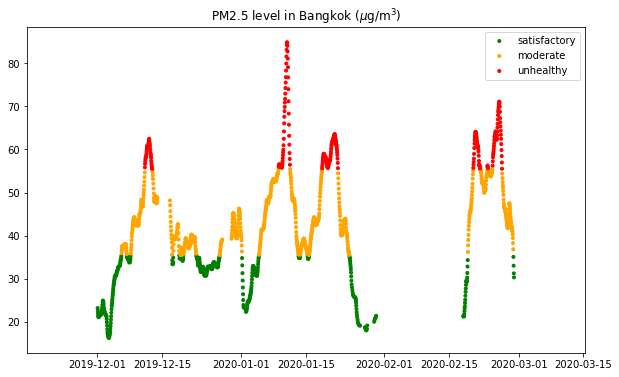

In [44]:
fig1 = plt.figure(figsize=(10, 6))


# make legend and plot each level at a time 
# Each level has to be plotted separtely to generate proper legend
for legend in ['satisfactory', 'moderate', 'unhealthy']:
    temp = pm25_secfield[pm25_secfield['level']==legend]
    #plot the data for each pollution level
    plt.scatter(temp.index, temp['PM2.5avg'], 
               c=temp['color'], marker='.', label=legend)

plt.legend(loc='upper right')
plt.title("PM2.5 level in Bangkok ($\mu$g/m$^3$)")


In [45]:
fig1.savefig('C:\\Users\\chath\\Desktop\\figouts\\bkk_fielddate.png')

**monthly avg analysis**

In [59]:
pm25_sel_decmar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1516 entries, 0 to 1515
Data columns (total 13 columns):
Time          1516 non-null object
PM2.5         1516 non-null float64
PM2.5avg      1516 non-null float64
Year          1516 non-null int64
Month         1516 non-null object
DayofMonth    1516 non-null int64
DayofWeek     1516 non-null object
TimeofDay     1516 non-null object
is_weekend    1516 non-null object
month-year    1516 non-null object
level         1516 non-null object
color         1516 non-null object
season        1516 non-null object
dtypes: float64(2), int64(2), object(9)
memory usage: 154.1+ KB


In [54]:
import numpy as np
pm25_sec18_2018 = pm25_sec18['2018']
pm25_sec19_2019 = pm25_sec19['2019']



# make a cross table with month as index, and day of month as columns
date_month_2018 = pd.crosstab(pm25_sec18_2018['Month'], pm25_sec18_2018['DayofMonth'], pm25_sec18_2018['PM2.5avg'], aggfunc=np.mean)
month_name18=pd.date_range('2018-01','2018-12', freq='MS').strftime("%B").tolist()
date_month_2018 = date_month_2018.reindex(month_name18)


date_month_2019 = pd.crosstab(pm25_sec19_2019['Month'], pm25_sec19_2019['DayofMonth'], pm25_sec19_2019['PM2.5avg'], aggfunc=np.mean)
month_name19=pd.date_range('2019-01','2019-12', freq='MS').strftime("%B").tolist()
date_month_2019 = date_month_2019.reindex(month_name19)




'dec2019march20 = date_month_2019.tail(1).append(date_month_2020)\nmonth_name1=pd.date_range(\'2019-12\',\'2020-03\', freq=\'MS\').strftime("%B").tolist()\ndec2019march20 = date_month_2020.reindex(month_name1)\ndec2019march20 '

In [78]:
date_month_field = pd.crosstab(pm25_secfield['Month'], pm25_secfield['DayofMonth'], pm25_secfield['PM2.5avg'], aggfunc=np.mean)
month_namef=pd.date_range('2019-12','2020-02', freq='MS').strftime("%B").tolist()
date_month_field = date_month_field.reindex(month_namef)

date_month_field

DayofMonth,1,2,3,4,5,6,7,8,9,10,...,22,23,24,25,26,27,28,29,30,31
Month,,,,,,,,,,,,,,,,,,,,,
December,21.873007,22.879514,17.998090,27.684375,32.351326,36.848785,35.526215,39.757609,43.062292,46.683333,...,35.670455,32.675174,31.512674,32.694444,33.348090,36.163889,NaN,39.316667,42.452778,42.811979
January,29.164931,24.164236,30.347049,32.256424,40.258160,46.288368,50.621528,53.129167,55.995486,70.305382,...,44.615972,42.430903,34.665217,25.631845,20.325463,18.520833,18.445833,20.455556,21.141667,NaN
February,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,51.525000,54.693403,58.366319,66.585069,55.267014,44.114236,41.606944,30.350000,NaN,NaN


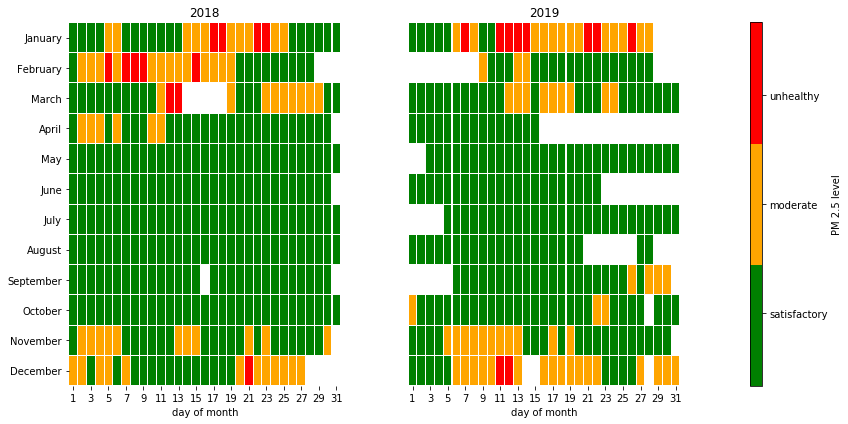

In [57]:
colors = ['green', 'orange','red']
levels = [0, 35.4, 55.4]
cmap, norm = mpl.colors.from_levels_and_colors(levels,colors,'max')

fig = plt.figure(figsize= (12,6))
# make a grid space for each subplot
gs = GridSpec(1,10)
# plot the first heatmap for 2017 data
ax1 = fig.add_subplot(gs[0:4])
sns.heatmap(date_month_2018, cmap=cmap, norm=norm, linewidth=0.05,vmax=70, cbar=False, ax=ax1)
ax1.yaxis.label.set_visible(False)
plt.title('2018')
plt.xlabel('day of month')

# plot the first heatmap for 2018 data
ax2 = fig.add_subplot(gs[4:8])
ax2 = sns.heatmap(date_month_2019, cmap=cmap, norm=norm, linewidth=0.05,vmax=70, cbar=False)
plt.title('2019')
plt.xlabel('day of month')
ax2.get_yaxis().set_visible(False)

# plot monthly average as a horizontal side bar, and color coded them
"""ax3 = fig.add_subplot(gs[8])
monthavg = pm25_sel[['Month','PM2.5avg']].groupby('Month').mean()
monthavg = monthavg.reindex(reversed(month_name))
monthavg['color'] = pd.cut(monthavg['PM2.5avg'],bins = [0, 35.5, 55.5, 150.4], 
                       labels=['green', 'orange','red'],
                      include_lowest=True, right=False).astype(str)
monthavg.plot(y='PM2.5avg', kind='barh',color = monthavg['color'], legend=False, ax=ax3,
             edgecolor='black')
ax3.get_yaxis().set_visible(False)
plt.title('monthly \n average')"""

# plot the colorbar on the further right
cmap2 = mpl.colors.ListedColormap(colors=['green','orange','red'])
ax4 = fig.add_subplot(gs[8])
ax4.set_aspect(30)
cbar = mpl.colorbar.ColorbarBase(cmap=cmap2, ax=ax4)
cbar.set_ticks([0.2, 0.5, 0.8])
cbar.set_ticklabels(['satisfactory', 'moderate', 'unhealthy'])
cbar.set_label('PM 2.5 level')

plt.tight_layout()

In [58]:
fig.savefig('C:\\Users\\chath\\Desktop\\figouts\\Dailyavg1819.png')

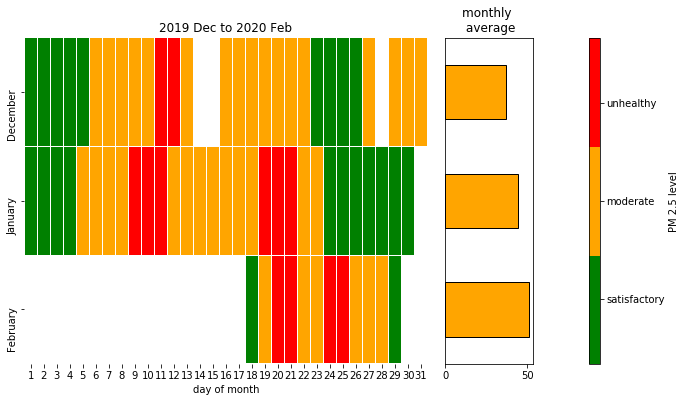

In [80]:
colors = ['green', 'orange','red']
levels = [0, 35.4, 55.4]
cmap, norm = mpl.colors.from_levels_and_colors(levels,colors,'max')

fig = plt.figure(figsize= (11,6))
# make a grid space for each subplot
gs = GridSpec(1,6)
# plot the first heatmap for 2017 data
ax1 = fig.add_subplot(gs[0:4])
sns.heatmap(date_month_field, cmap=cmap, norm=norm, linewidth=0.05,vmax=70, cbar=False, ax=ax1)
ax1.yaxis.label.set_visible(False)
plt.title('2019 Dec to 2020 Feb')
plt.xlabel('day of month')

ax2 = fig.add_subplot(gs[4])
monthavg = pm25_secfield[['Month','PM2.5avg']].groupby('Month').mean()
monthavg = monthavg.reindex(reversed(month_namef))
monthavg['color'] = pd.cut(monthavg['PM2.5avg'],bins = [0, 35.5, 55.5, 150.4], 
                       labels=['green', 'orange','red'],
                      include_lowest=True, right=False).astype(str)
monthavg.plot(y='PM2.5avg', kind='barh',color = monthavg['color'], legend=False, ax=ax2,
             edgecolor='black')
ax2.get_yaxis().set_visible(False)
plt.title('monthly \n average')

# plot the colorbar on the further right
cmap2 = mpl.colors.ListedColormap(colors=['green','orange','red'])
ax4 = fig.add_subplot(gs[5])
ax4.set_aspect(30)
cbar = mpl.colorbar.ColorbarBase(cmap=cmap2, ax=ax4)
cbar.set_ticks([0.2, 0.5, 0.8])
cbar.set_ticklabels(['satisfactory', 'moderate', 'unhealthy'])
cbar.set_label('PM 2.5 level')

#plt.tight_layout()

In [81]:
fig.savefig('C:\\Users\\chath\\Desktop\\figouts\\fielddailyavg1819.png')